<a href="https://colab.research.google.com/github/geporys/ts-project-assignment-hse-2023/blob/main/ExportForecastLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys 
sys.path.append("/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/functions")

In [2]:
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
from functions.data import get_NIC_from_yFinance, get_nickel_data_from_businessinsider, get_rates, union_data_in_one_df, get_AUDIDR_from_yFinance, get_endog_and_exog
from functions.chart import plot_nick_rate_nic
from functions.model import first_model


In [3]:
test = yf.Ticker("NIC.AX")
test_df = test.history(period="max")
test_df = test_df.asfreq(freq='M', method='ffill').fillna(method='ffill')

In [4]:
test_df = test_df.diff()
test_df = test_df.fillna(0)

In [5]:
# plot_pacf(test_df['Close'], lags=12, method='ywm', title="PACF Nickel Industries")

# plt.savefig('images/PACF Nickel Industries.png', dpi=300)

In [6]:
# plot_acf(test_df['Close'], lags=12,  title="ACF Nickel Industries", alpha=0.1)

# plt.savefig('images/ACF Nickel Industries.png', dpi=300)

In [7]:
currency_df = get_AUDIDR_from_yFinance()

<AxesSubplot: xlabel='Date'>

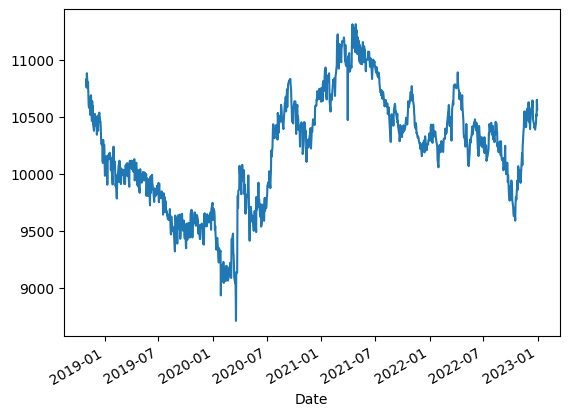

In [8]:
currency_df['Close'].plot()

In [9]:
currency_df.index.normalize()

DatetimeIndex(['2018-10-31 00:00:00+11:00', '2018-11-01 00:00:00+11:00',
               '2018-11-02 00:00:00+11:00', '2018-11-05 00:00:00+11:00',
               '2018-11-06 00:00:00+11:00', '2018-11-07 00:00:00+11:00',
               '2018-11-08 00:00:00+11:00', '2018-11-09 00:00:00+11:00',
               '2018-11-12 00:00:00+11:00', '2018-11-13 00:00:00+11:00',
               ...
               '2022-12-19 00:00:00+11:00', '2022-12-20 00:00:00+11:00',
               '2022-12-21 00:00:00+11:00', '2022-12-22 00:00:00+11:00',
               '2022-12-23 00:00:00+11:00', '2022-12-26 00:00:00+11:00',
               '2022-12-27 00:00:00+11:00', '2022-12-28 00:00:00+11:00',
               '2022-12-29 00:00:00+11:00', '2022-12-30 00:00:00+11:00'],
              dtype='datetime64[ns, Australia/Sydney]', name='Date', length=1088, freq=None)

In [10]:
nic_df = get_NIC_from_yFinance()

In [11]:
nic_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-31 00:00:00+11:00,0.243202,0.252209,0.234194,0.247705,640285,0.0,0.0
2018-11-01 00:00:00+11:00,0.247705,0.270224,0.234194,0.243202,1726009,0.0,0.0
2018-11-02 00:00:00+11:00,0.252209,0.252209,0.245003,0.247705,181966,0.0,0.0
2018-11-05 00:00:00+11:00,0.252209,0.256713,0.247705,0.247705,1444336,0.0,0.0
2018-11-06 00:00:00+11:00,0.243202,0.261217,0.238698,0.261217,546481,0.0,0.0
...,...,...,...,...,...,...,...
2022-09-26 00:00:00+10:00,0.779563,0.789369,0.764854,0.779563,15205621,0.0,0.0
2022-09-27 00:00:00+10:00,0.779563,0.794272,0.769757,0.784466,12283210,0.0,0.0
2022-09-28 00:00:00+10:00,0.789369,0.789369,0.745243,0.755049,15720741,0.0,0.0


In [12]:
(nic_df, nickel_df) = get_nickel_data_from_businessinsider(nic_df)

In [13]:
nickel_df[nickel_df['Close'].isnull()]

,Close,Open,High,Low,Volume,Estimate,Date
Date,,,,,,,


In [14]:
rates = get_rates(nic_df)

In [15]:
ind_exp = pd.read_excel("forecasting_ts_project_raw_data/TABEL5_14_volume by sector.xls", sheet_name='5.14', header=4)

In [16]:
ind_exp = ind_exp.transpose().reset_index()

In [17]:
ind_exp_cols = ['Year', 'Month'] + list(ind_exp.iloc[176][2:69]) + ['drop1', 'drop2']
ind_exp.columns = ind_exp_cols

In [18]:
ind_exp = ind_exp[3:174].drop(columns=['drop1', 'drop2'])

In [19]:
bo = ~ind_exp['Year'].str.contains('Unnamed').fillna(False)
ind_exp['Year'] = ind_exp['Year'].where(bo).fillna(method='ffill')

In [20]:
ind_exp = ind_exp[~ind_exp['Month'].isna()]

In [21]:
ind_exp['Month'] = ind_exp['Month'].str.replace('*', '')

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_88643/3288374492.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ind_exp['Month'] = ind_exp['Month'].str.replace('*', '')


In [22]:
ind_exp['Day'] = 1
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
ind_exp.replace({'Month': months}, inplace=True)

In [23]:
dt = pd.to_datetime(ind_exp[['Year', 'Month', 'Day']], format="%Y%m%d")
ind_exp['Date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in dt]

In [24]:
ind_exp.set_index('Date', inplace=True)
ind_exp = ind_exp.asfreq(freq='m', method='ffill').fillna(method='ffill')

In [25]:
ind_exp = ind_exp[['Base metal products', 'Nickel ore']]
ind_exp = ind_exp.asfreq(freq='B').fillna(method='ffill')

# Slice period 
ind_exp = ind_exp['2018-10-31':'2022-09-30']

<AxesSubplot: xlabel='Date'>

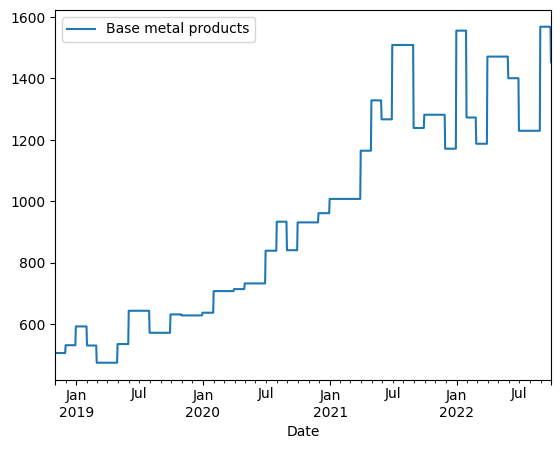

In [26]:
ind_exp.plot()

In [27]:
ind_exp[ind_exp['Base metal products'].isnull()]

,Base metal products,Nickel ore
Date,,


In [28]:
ind_exp

,Base metal products,Nickel ore
Date,,
2018-10-31 00:00:00+11:00,506.75,1968.14
2018-11-01 00:00:00+11:00,506.75,1968.14
2018-11-02 00:00:00+11:00,506.75,1968.14
2018-11-05 00:00:00+11:00,506.75,1968.14
2018-11-06 00:00:00+11:00,506.75,1968.14
...,...,...
2022-09-26 00:00:00+10:00,1568.34,-
2022-09-27 00:00:00+10:00,1568.34,-
2022-09-28 00:00:00+10:00,1568.34,-


In [29]:
mining = pd.DataFrame(data=[
    {'date': '2018-07-01', 'value': 36933},
    {'date': '2018-08-01', 'value': 40904},
    {'date': '2018-09-01', 'value': 48155},
    {'date': '2018-10-01', 'value': 40579},
    {'date': '2018-11-01', 'value': 43322},
    {'date': '2018-12-01', 'value': 39275},
    {'date': '2019-01-01', 'value': 39848},
    {'date': '2019-02-01', 'value': 42772},
    {'date': '2019-03-01', 'value': 44576},
    {'date': '2019-04-01', 'value': 20509},
    {'date': '2019-05-01', 'value': 33281},
    {'date': '2019-06-01', 'value': 24461},
    {'date': '2019-07-01', 'value': 57000},
    {'date': '2019-08-01', 'value': 64000},
    {'date': '2019-09-01', 'value': 77950},
    {'date': '2019-10-01', 'value': 69734},
    {'date': '2019-11-01', 'value': 56086},
    {'date': '2019-12-01', 'value': 68339},
    {'date': '2020-01-01', 'value': 50600},
    {'date': '2020-02-01', 'value': 49666},
    {'date': '2020-03-01', 'value': 49643},
    {'date': '2020-04-01', 'value': 12500},
    {'date': '2020-05-01', 'value': 25400},
    {'date': '2020-06-01', 'value': 24600},
    {'date': '2020-07-01', 'value': 9500},
    {'date': '2020-08-01', 'value': 45900},
    {'date': '2020-09-01', 'value': 102800},
    {'date': '2020-10-01', 'value': 174193},
    {'date': '2020-11-01', 'value': 173930},
    {'date': '2020-12-01', 'value': 151764},
    {'date': '2021-01-01', 'value': 156039},
    {'date': '2021-02-01', 'value': 117728},
    {'date': '2021-03-01', 'value': 182720},
    {'date': '2021-04-01', 'value': 196617},
    {'date': '2021-05-01', 'value': 142056},
    {'date': '2021-06-01', 'value': 236118},
    {'date': '2021-07-01', 'value': 166506},
    {'date': '2021-08-01', 'value': 193068},
    {'date': '2021-09-01', 'value': 219582},
    {'date': '2021-10-01', 'value': 283494},
    {'date': '2021-11-01', 'value': 213090},
    {'date': '2021-12-01', 'value': 313740},
    {'date': '2022-01-01', 'value': 792630/3},
    {'date': '2022-02-01', 'value': 792630/3},
    {'date': '2022-03-01', 'value': 792630/3},
    {'date': '2022-04-01', 'value': 599590/3},
    {'date': '2022-05-01', 'value': 599590/3},
    {'date': '2022-06-01', 'value': 599590/3},
    {'date': '2022-07-01', 'value': 339672},
    {'date': '2022-08-01', 'value': 205722},
    {'date': '2022-09-30', 'value': 301866},
])


mining['date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in mining['date']]


mining = mining.set_index('date')
mining = mining.asfreq(freq='B').fillna(method='ffill')
mining = mining[mining.index >= nic_df.index[0]]

In [30]:
mining[mining['value'].isnull()]

,value
date,


<AxesSubplot: xlabel='date'>

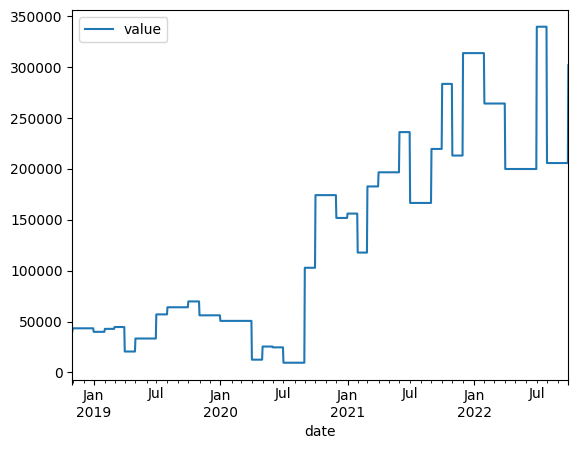

In [31]:
mining.plot()

In [32]:
production = pd.DataFrame(data=[
     {'date': '2018-01-01', 'value': 0},
     {'date': '2018-02-01', 'value': 0},
     {'date': '2018-03-01', 'value': 0},
     {'date': '2018-04-01', 'value': 0},
     {'date': '2018-05-01', 'value': 0},
     {'date': '2018-06-01', 'value': 0},
     {'date': '2018-07-01', 'value': 0},
     {'date': '2018-08-01', 'value': 0},
     {'date': '2018-09-01', 'value': 0},
     {'date': '2018-10-01', 'value': 0},
     {'date': '2018-11-01', 'value': 0},
     {'date': '2018-12-01', 'value': 0},
     {'date': '2019-01-01', 'value': 67.5},
     {'date': '2019-02-01', 'value': 1802},
     {'date': '2019-03-01', 'value': 6502},
     {'date': '2019-04-01', 'value': 8684.8},
     {'date': '2019-05-01', 'value': 11320.5+123.1},
     {'date': '2019-06-01', 'value': 1251.1 + 2354.0},
     {'date': '2019-07-01', 'value': 12700 + 8053},
     {'date': '2019-08-01', 'value': 13405 + 12389},
     {'date': '2019-09-01', 'value': 13451 + 12375},
     {'date': '2019-10-01', 'value': 14937.5 + 13595.3},
     {'date': '2019-11-01', 'value': 12978.0 + 13433.4},
     {'date': '2019-12-01', 'value': 12995.2 + 12076.0},
     {'date': '2020-01-01', 'value': 26858},
     {'date': '2020-02-01', 'value': 25449},
     {'date': '2020-03-01', 'value': 27090},
     {'date': '2020-04-01', 'value': 23179},
     {'date': '2020-05-01', 'value': 24777},
     {'date': '2020-06-01', 'value': 21645},
     {'date': '2020-07-01', 'value': 20768},
     {'date': '2020-08-01', 'value': 23326},
     {'date': '2020-09-01', 'value': 25737},
     {'date': '2020-10-01', 'value': 26068.3},
     {'date': '2020-11-01', 'value': 24542.3},
     {'date': '2020-12-01', 'value': 26456.1},
     {'date': '2021-01-01', 'value': 22170.9},
     {'date': '2021-02-01', 'value': 24497.3},
     {'date': '2021-03-01', 'value': 25271.1},
     {'date': '2021-04-01', 'value': 23991.5},
     {'date': '2021-05-01', 'value': 26383.7},
     {'date': '2021-06-01', 'value': 24111.3},
     {'date': '2021-07-01', 'value': 25146.1},
     {'date': '2021-08-01', 'value': 26305.5},
     {'date': '2021-09-01', 'value': 21702.8},
     {'date': '2021-10-01', 'value': 24589},
     {'date': '2021-11-01', 'value': 26028},
     {'date': '2021-12-01', 'value': 28155}, 
     {'date': '2022-01-01', 'value': 12222 + 12812},
     {'date': '2022-02-01', 'value': 11853 + 11863 + 1939},
     {'date': '2022-03-01', 'value': 12783 + 12556 + 5571 },
     {'date': '2022-04-01', 'value': 114106 / 3},
     {'date': '2022-05-01', 'value': 114106 / 3},
     {'date': '2022-06-01', 'value': 114106 / 3},
     {'date': '2022-07-01', 'value': 145180 / 3},
     {'date': '2022-08-01', 'value': 145180 / 3},
     {'date': '2022-09-30', 'value': 145180 / 3},
])

production['date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in production['date']]


production = production.set_index('date')
production = production.asfreq(freq='B').fillna(method='ffill')
production = production[production.index >= nic_df.index[0]]

In [33]:
production[production['value'].isnull()]

,value
date,


<AxesSubplot: xlabel='date'>

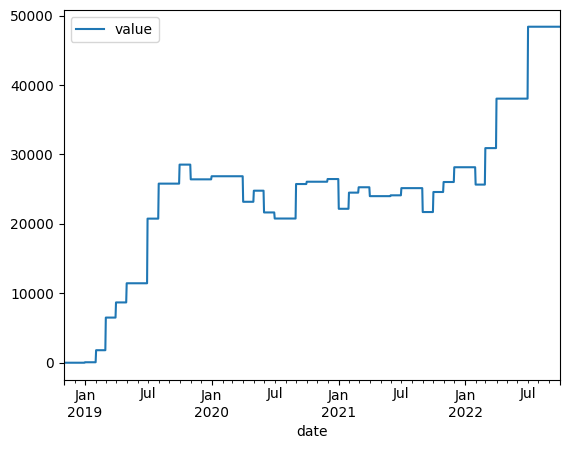

In [34]:
production.plot()

In [35]:
rates

,rate
date,
2018-10-31 00:00:00+11:00,1.50
2018-11-01 00:00:00+11:00,1.50
2018-11-02 00:00:00+11:00,1.50
2018-11-05 00:00:00+11:00,1.50
2018-11-06 00:00:00+11:00,1.50
...,...
2022-09-26 00:00:00+10:00,2.35
2022-09-27 00:00:00+10:00,2.35
2022-09-28 00:00:00+10:00,2.35


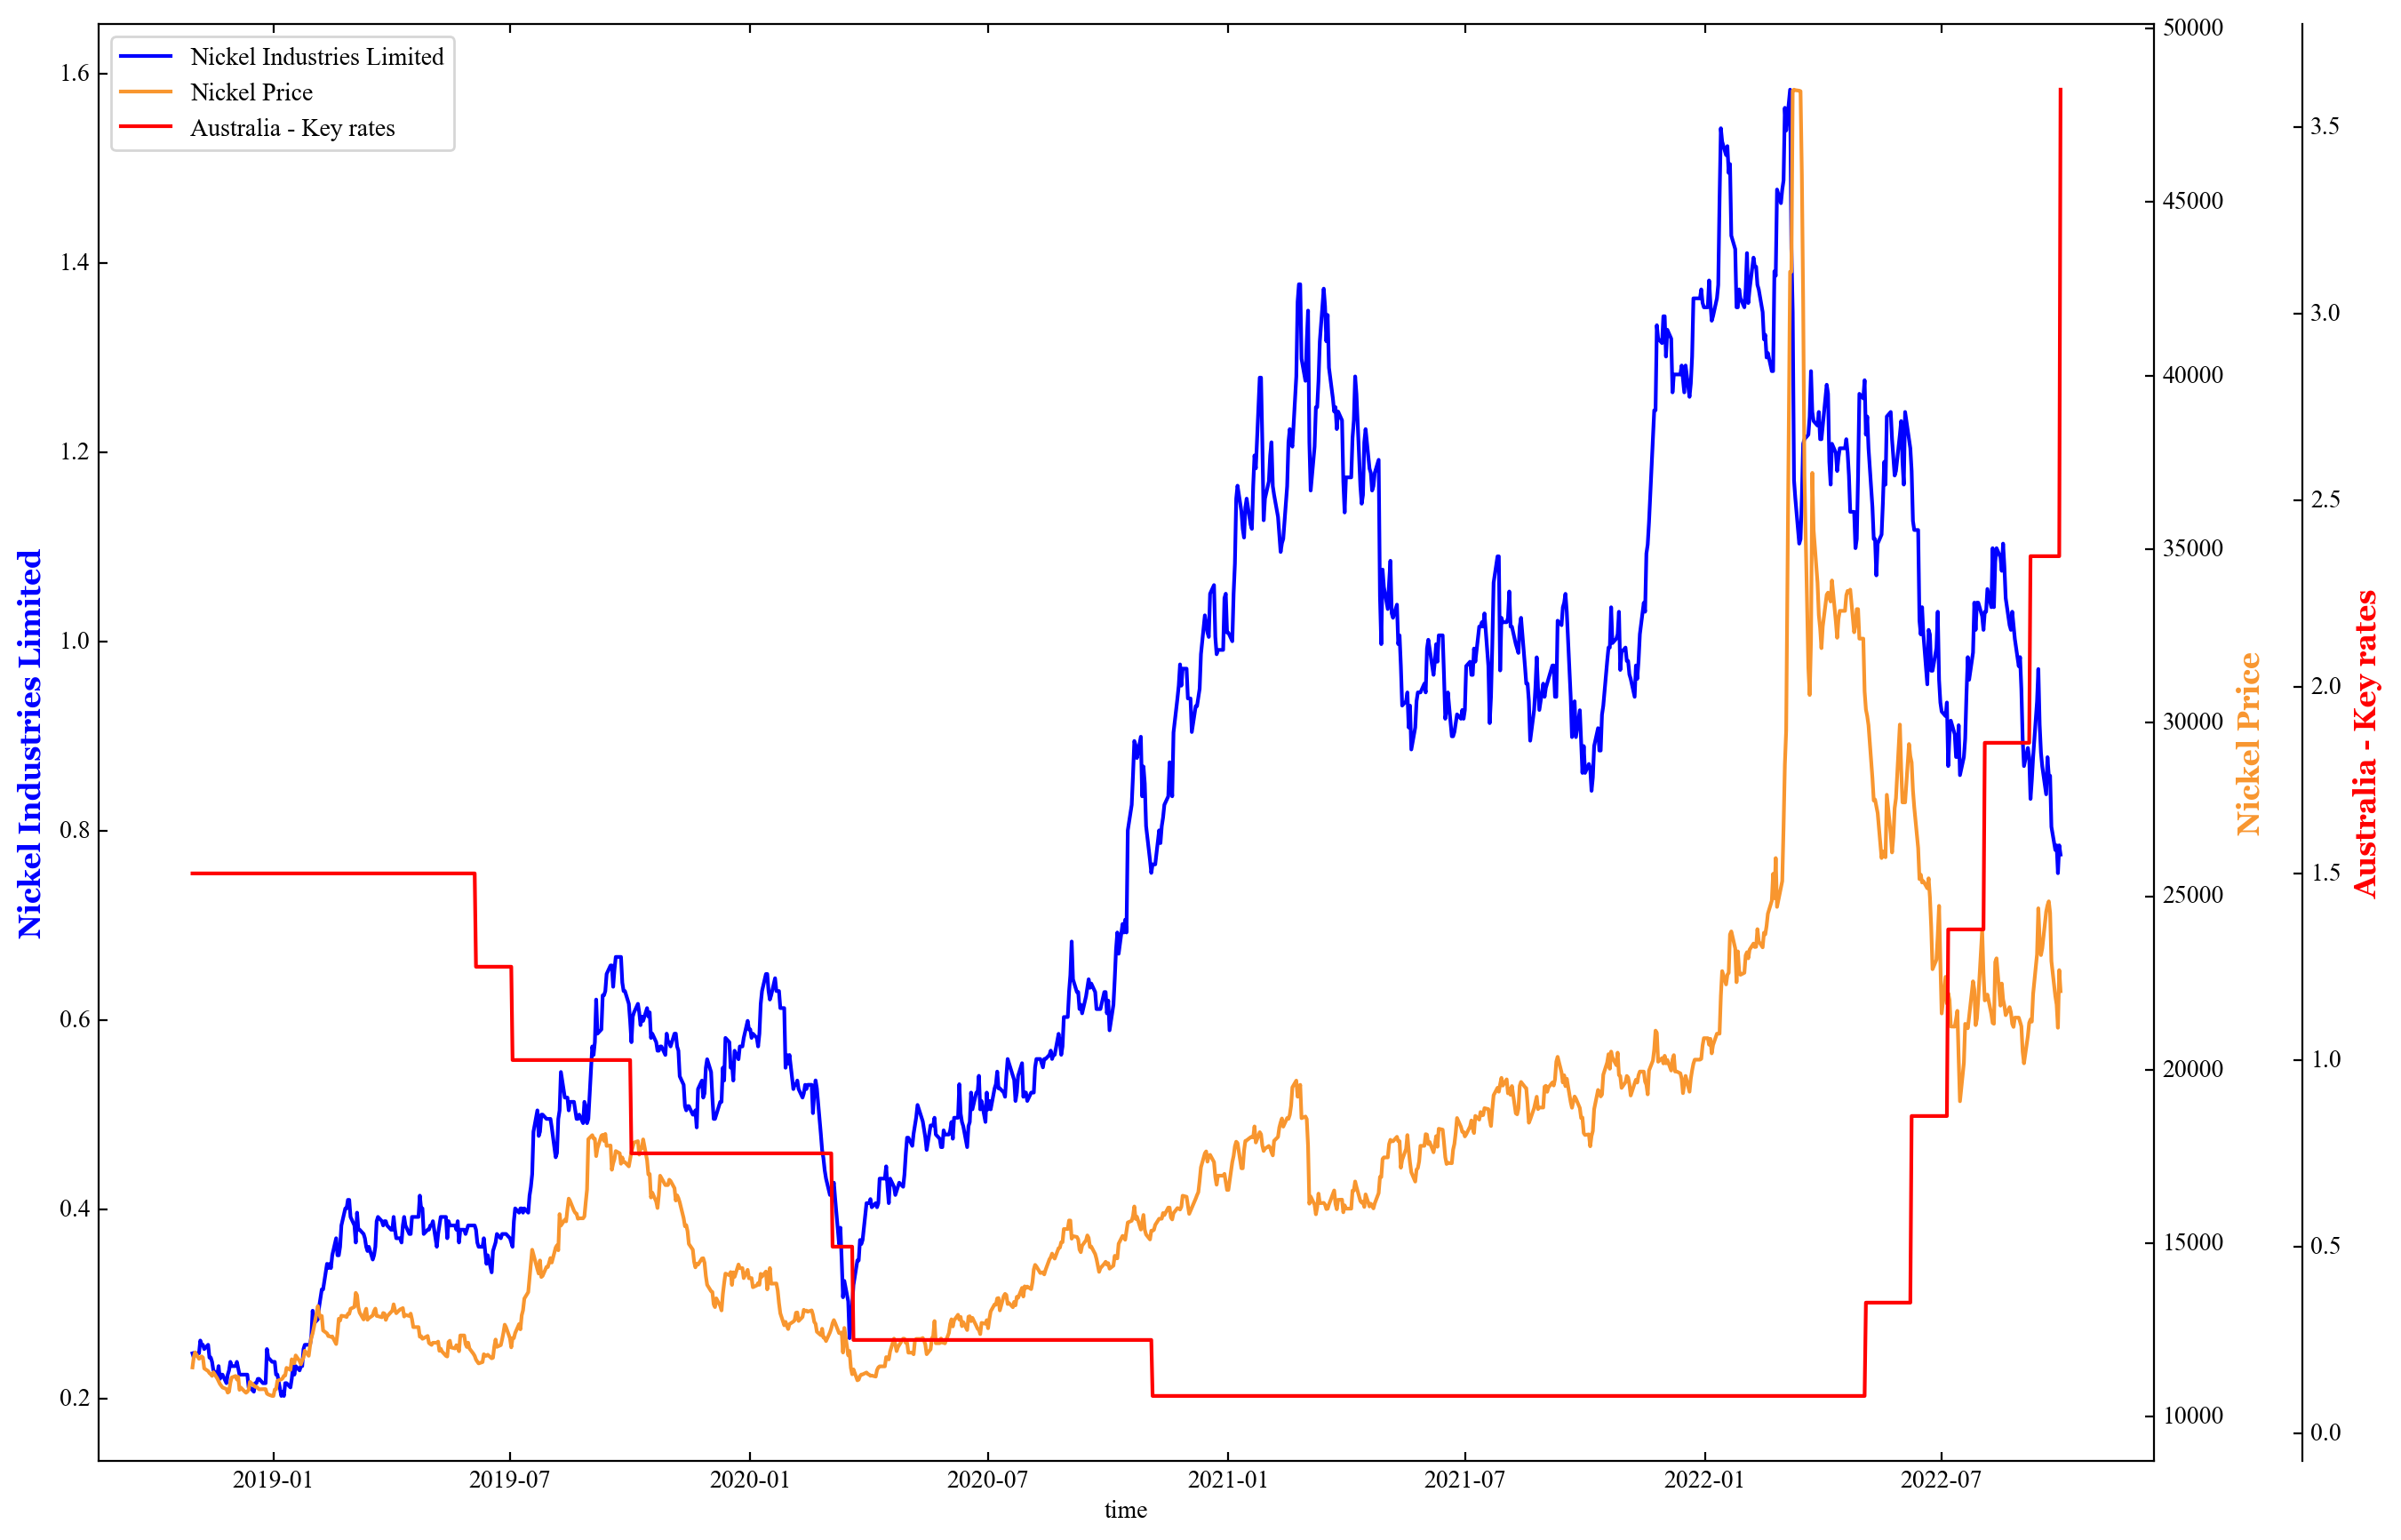

In [36]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

plot_nick_rate_nic(nickel_df, rates, nic_df)

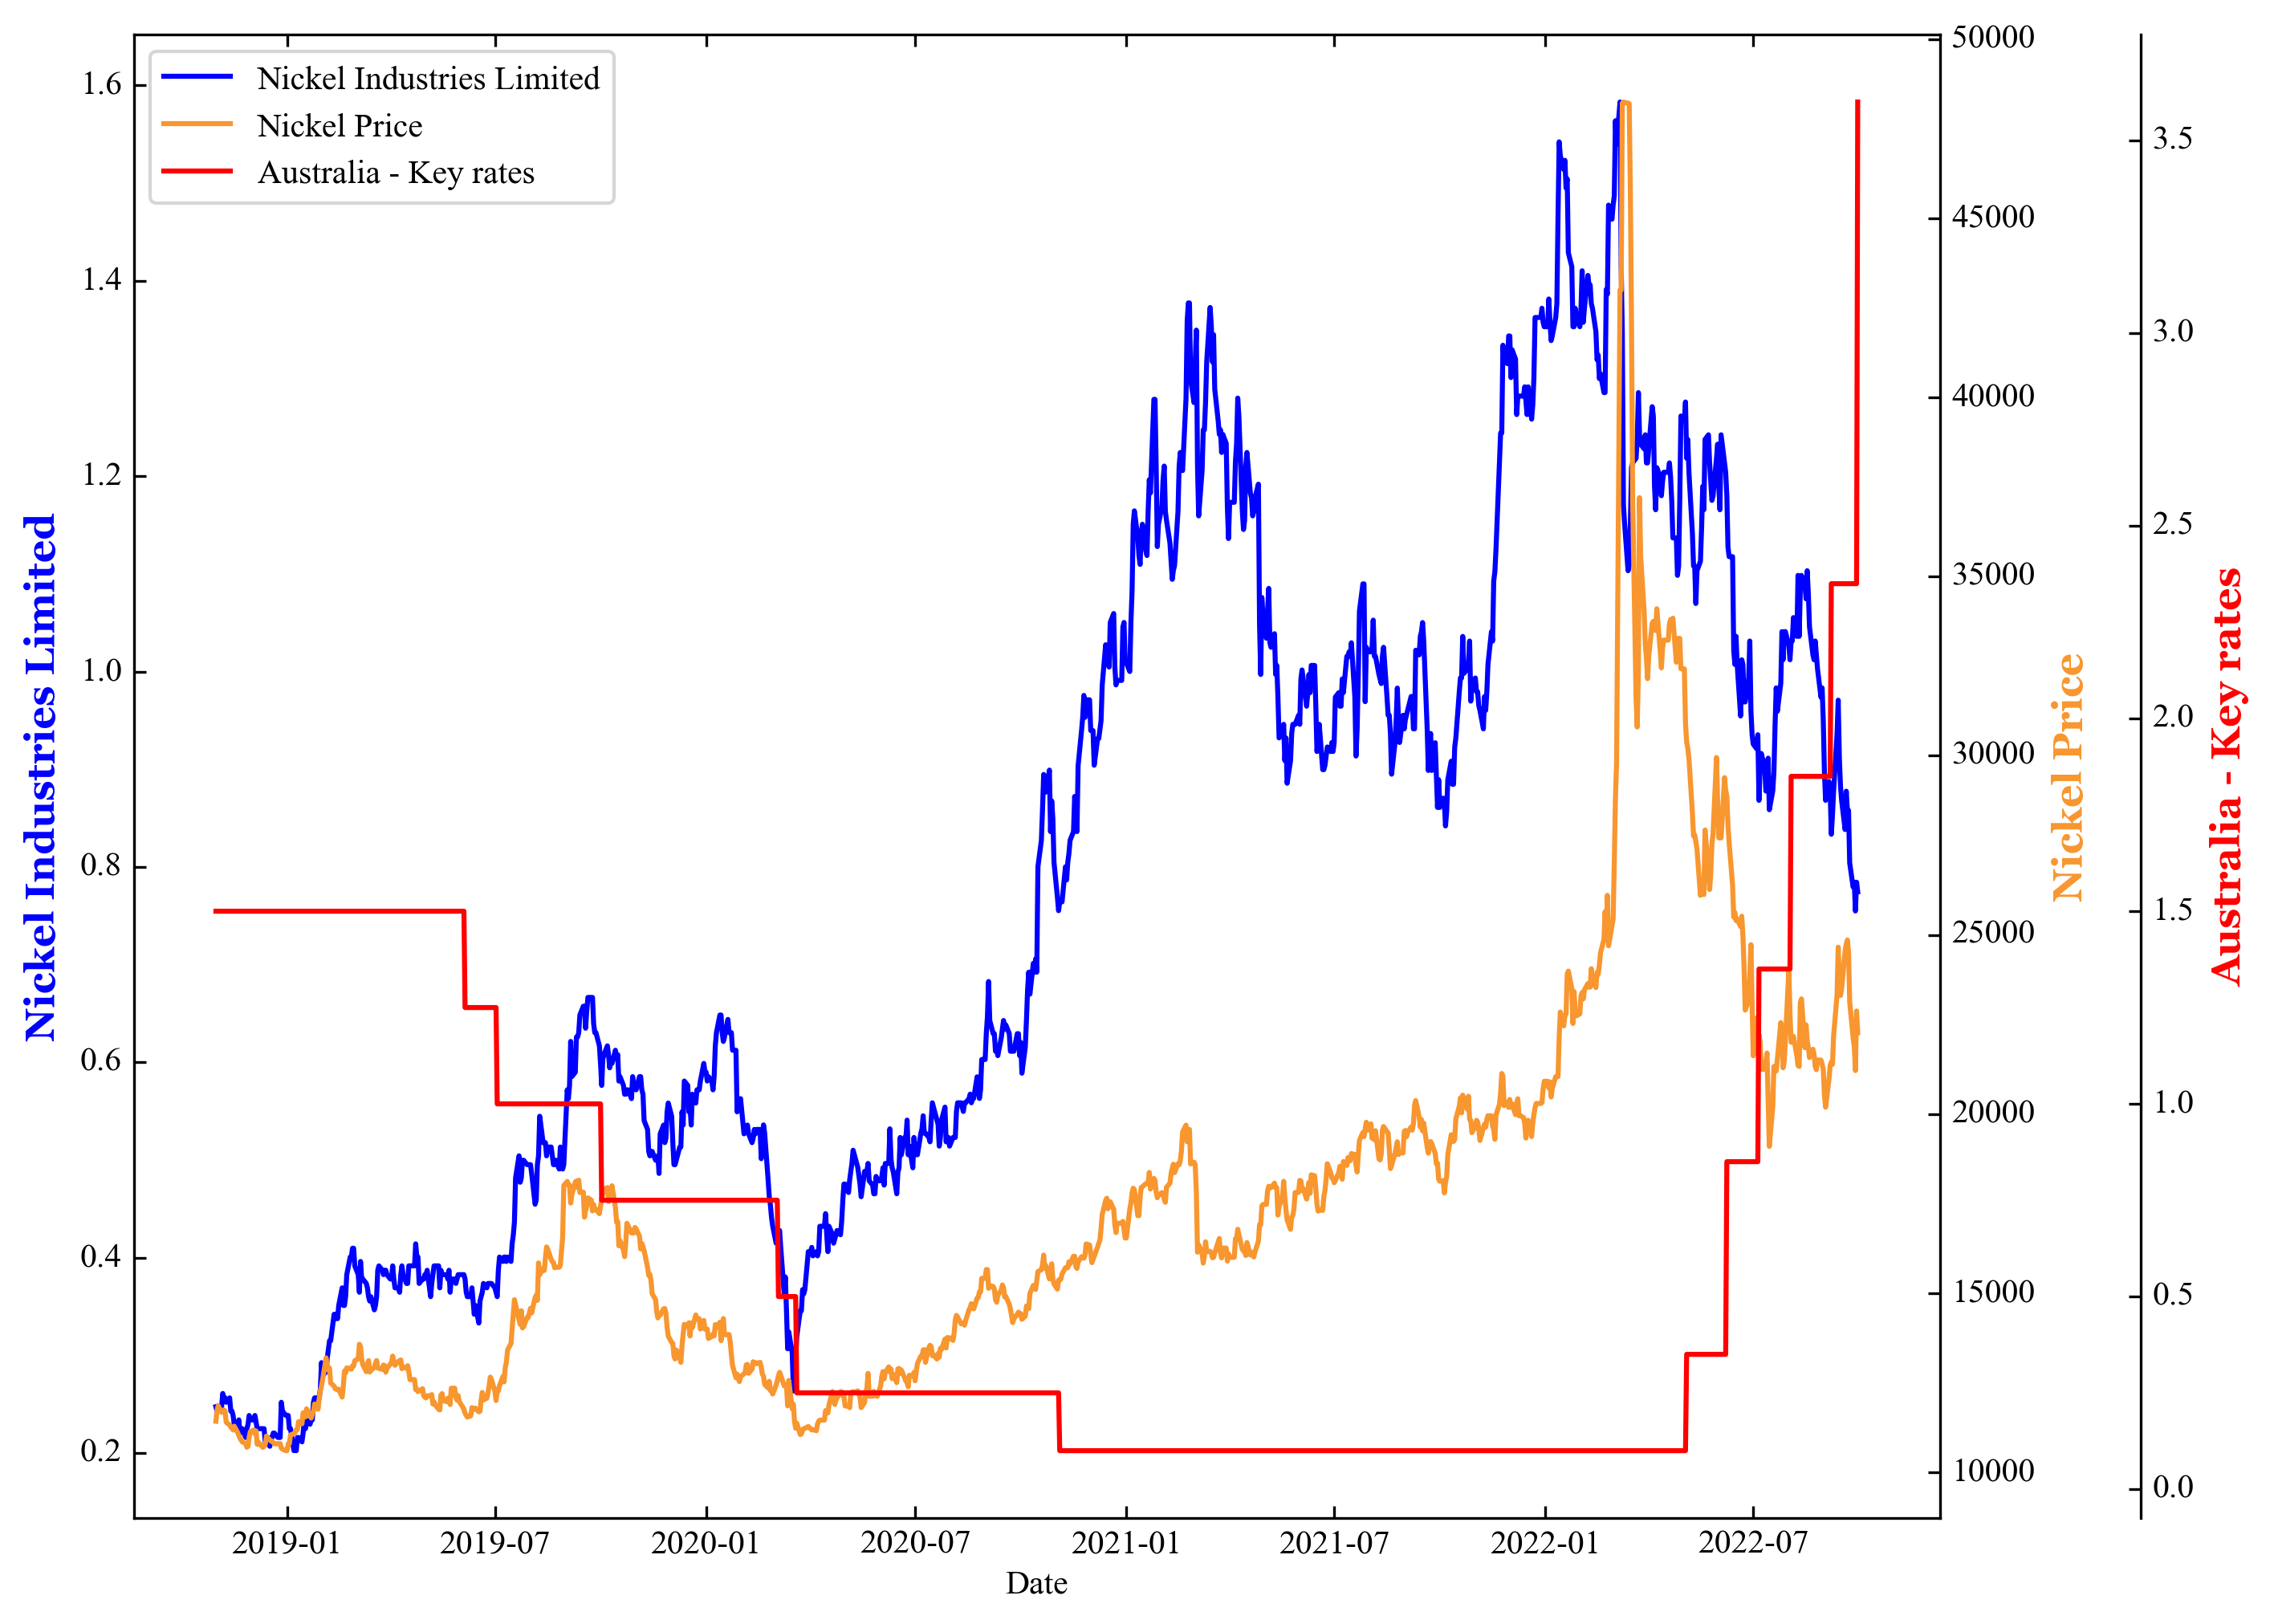

In [37]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
    
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)
    
p1, = host.plot(nic_df.index, nic_df['Close'], label="Nickel Industries Limited", color="blue")
p2, = par1.plot(nic_df.index, nickel_df['Close'], label="Nickel Price", color="#f8962f")
p3, = par2.plot(nic_df.index, rates['rate'], label="Australia - Key rates", color="red")
    
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Nickel Industries Limited")
par1.set_ylabel("Nickel Price")
par2.set_ylabel("Australia - Key rates")
    
host.legend()
    
host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
    
host.axis["left"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par1.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par2.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
    
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.set_dpi(300)

# plt.savefig('images/Example.png', dpi=300)

plt.show()

In [38]:
data = union_data_in_one_df(nickel_df, rates, nic_df, currency_df, production, mining, ind_exp)

In [39]:
(endog, exog) = get_endog_and_exog(data)

Text(0.5, 0.98, '')

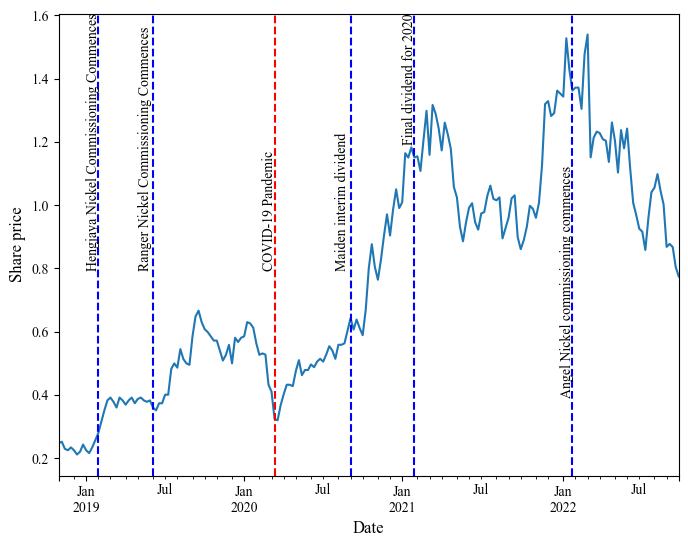

In [40]:
plt.rcParams["font.family"] = "Times New Roman"

ax = data[endog].plot(figsize=(8, 6))

ax.axvline('2020-03-11', color='red', linestyle='--',)
plt.text('2020-02-11', 0.8, s='COVID-19 Pandemic', rotation=90)


ax.axvline('2019-02-01', color='blue', linestyle='--',)
plt.text('2019-01-01', 0.8, s='Hengjaya Nickel Commissioning Commences', rotation=90)

ax.axvline('2019-06-03', color='blue', linestyle='--',)
plt.text('2019-05-03', 0.8, s='Ranger Nickel Commissioning Commences', rotation=90)

ax.axvline('2020-08-31', color='blue', linestyle='--',)
plt.text('2020-07-31', 0.8, s='Maiden interim dividend', rotation=90)

ax.axvline('2021-01-28', color='blue', linestyle='--',)
plt.text('2020-12-28', 1.2, s='Final dividend for 2020', rotation=90)

ax.axvline('2022-01-27', color='blue', linestyle='--',)
plt.text('2021-12-27', 0.4, s='Angel Nickel commissioning commences', rotation=90)

ax.set_xlabel("")

ax.set_ylabel("Share price", fontname="Times New Roman", fontsize=12)

ax.set_label("")


ax.get_figure().gca().set_xlabel("Date", fontname="Times New Roman", fontsize=12)
ax.get_figure().suptitle('')

# ax.set_title("Share price of Nickel Industries Limited", fontname="Times New Roman", fontsize=18)

# plt.savefig('images/Share price of Nickel Industries Limited.png', dpi=300)

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

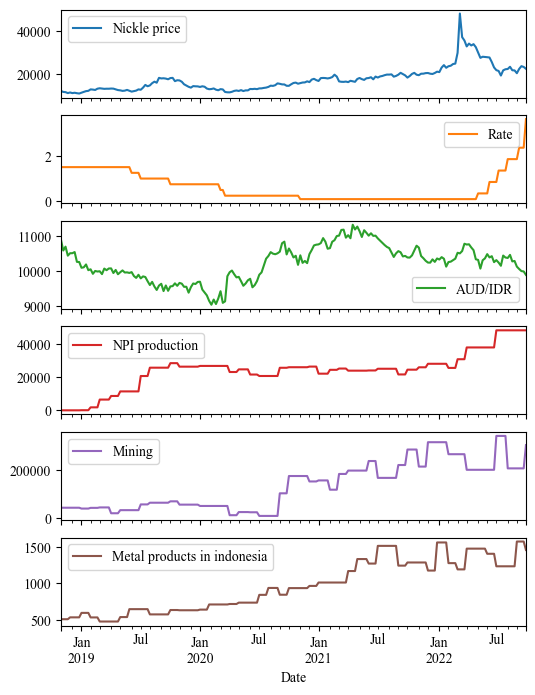

In [41]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

data[exog].plot(subplots=True, figsize=(6, 8), linewidth=1.5, sharey=False)

# plt.savefig('images/Data.png', dpi=300)

<AxesSubplot: >

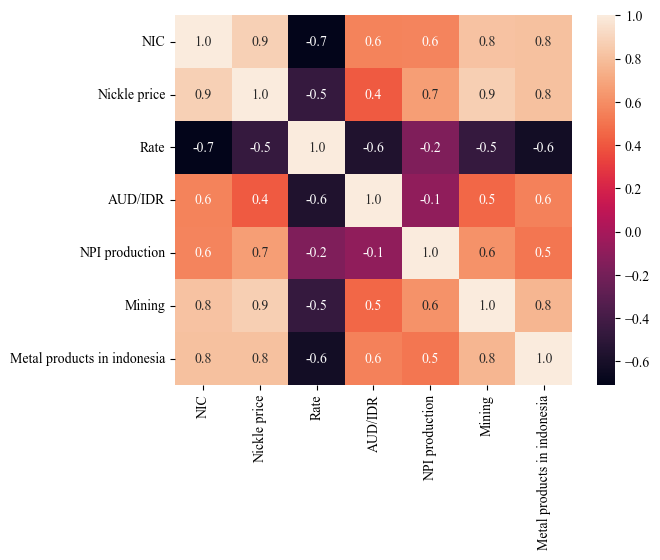

In [42]:
import seaborn as sns

sns.heatmap(data.corr(method="spearman"), annot=True, fmt=".1f")

# plt.savefig('images/Heatmap.png', dpi=300)

In [43]:
data = data.asfreq(freq='W-FRI').fillna(method='ffill')

In [44]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_price = adfuller(data['NIC'])
print("p-value of ADF: {}".format(float(adf_price[1].round(4))))

kpss_test = kpss(data['NIC'])
print("p-value of KPSS: {}".format(float(kpss_test[1].round(4))))

p-value of ADF: 0.4667
p-value of KPSS: 0.01


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [45]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

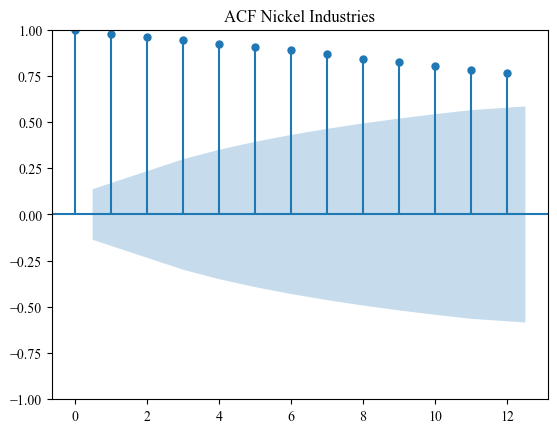

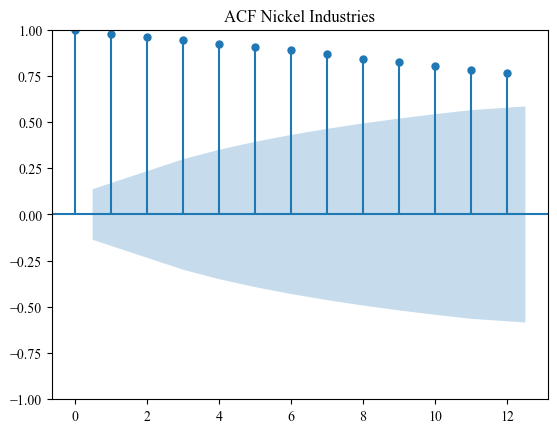

In [46]:
plot_acf(data['NIC'], lags=12,  title="ACF Nickel Industries")

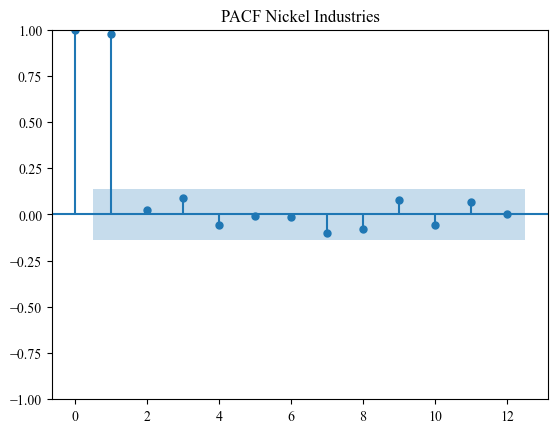

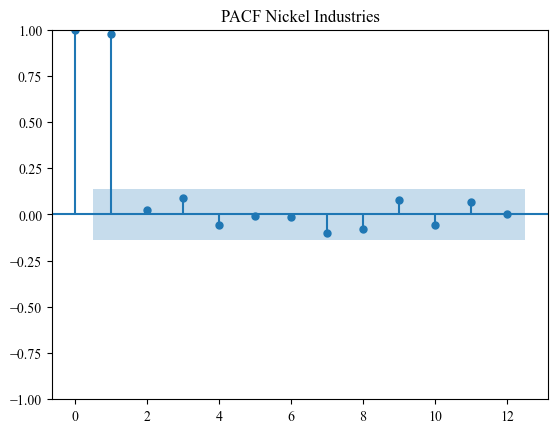

In [47]:
plot_pacf(data['NIC'], lags=12, method='ywm', title="PACF Nickel Industries")

# plt.savefig('images/PACF Nickel Industries.png', dpi=300)

In [48]:
data_diff = data.copy()
data_diff['NIC'] = data['NIC'].diff()
data_diff = data_diff.fillna(0)

In [49]:
data['NIC'].iloc[0]

0.2477053850889206

In [50]:
data_diff.head()

,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
Date,,,,,,,
2018-11-02 00:00:00+11:00,0.000000,11860.5,1.5,10885.799805,0.0,43322.0,506.75
2018-11-09 00:00:00+11:00,0.004504,11397.0,1.5,10583.400391,0.0,43322.0,506.75
2018-11-16 00:00:00+11:00,-0.022519,11287.0,1.5,10692.700195,0.0,43322.0,506.75
2018-11-23 00:00:00+11:00,-0.004504,10849.0,1.5,10437.400391,0.0,43322.0,506.75
2018-11-30 00:00:00+11:00,0.009007,11135.5,1.5,10506.400391,0.0,43322.0,532.13


In [51]:
data_diff['NIC'].cumsum().head()

Date
2018-11-02 00:00:00+11:00    0.000000
2018-11-09 00:00:00+11:00    0.004504
2018-11-16 00:00:00+11:00   -0.018015
2018-11-23 00:00:00+11:00   -0.022519
2018-11-30 00:00:00+11:00   -0.013511
Freq: W-FRI, Name: NIC, dtype: float64

In [52]:
data.head()

,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
Date,,,,,,,
2018-11-02 00:00:00+11:00,0.247705,11860.5,1.5,10885.799805,0.0,43322.0,506.75
2018-11-09 00:00:00+11:00,0.252209,11397.0,1.5,10583.400391,0.0,43322.0,506.75
2018-11-16 00:00:00+11:00,0.229690,11287.0,1.5,10692.700195,0.0,43322.0,506.75
2018-11-23 00:00:00+11:00,0.225187,10849.0,1.5,10437.400391,0.0,43322.0,506.75
2018-11-30 00:00:00+11:00,0.234194,11135.5,1.5,10506.400391,0.0,43322.0,532.13


In [123]:
data.describe()

,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.773109,17300.215854,0.626829,10226.793631,24104.616585,131909.830894,957.315024
std,0.351511,5701.492999,0.632465,501.638606,11106.524631,96718.721005,347.196964
min,0.211676,10647.000000,0.100000,9043.581055,0.000000,9500.000000,475.150000
25%,0.486403,12903.000000,0.100000,9890.727539,21645.000000,43322.000000,632.360000
50%,0.764341,16222.000000,0.250000,10286.171875,25271.100000,117728.000000,931.730000
75%,1.045725,19546.000000,1.000000,10550.154297,26858.000000,199863.333333,1267.050000
max,1.539806,48226.000000,3.600000,11315.769531,48393.333333,339672.000000,1568.340000


<AxesSubplot: xlabel='Date'>

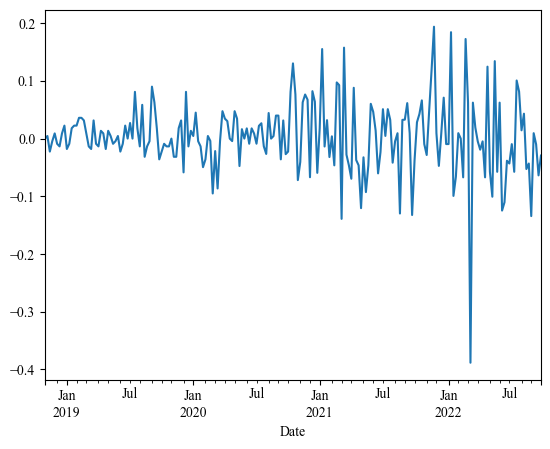

In [53]:
data_diff['NIC'].plot()

In [54]:
adf_price = adfuller(data_diff['NIC'])
print("p-value of ADF: {}".format(float(adf_price[1].round(4))))

kpss_test = kpss(data_diff['NIC'])
print("p-value of KPSS: {}".format(float(kpss_test[1].round(4))))

p-value of ADF: 0.0
p-value of KPSS: 0.1


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


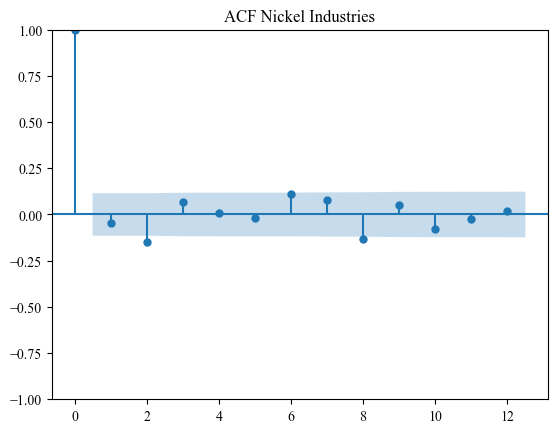

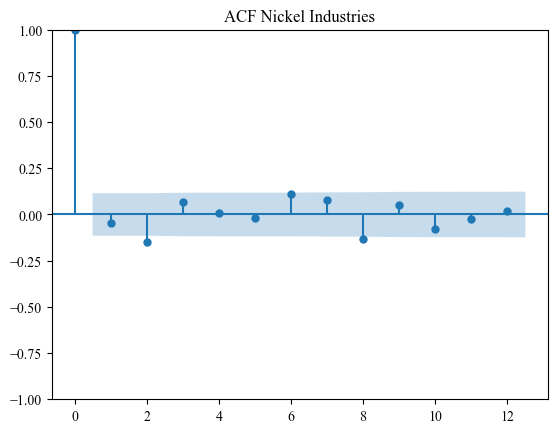

In [55]:
plot_acf(data_diff['NIC'], lags=12,  title="ACF Nickel Industries", alpha=0.1)

# plt.savefig('images/ACF Nickel Industries.png', dpi=300)

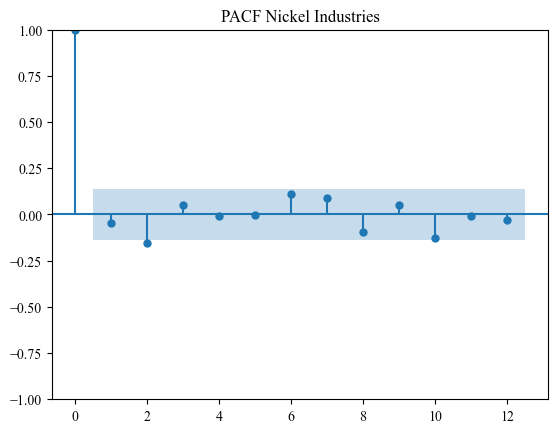

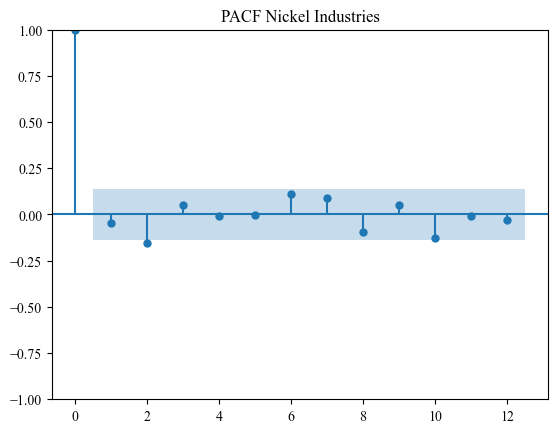

In [56]:
plot_pacf(data_diff['NIC'], lags=12, method='ywm', title="PACF Nickel Industries")

# plt.savefig('images/PACF Nickel Industries.png', dpi=300)

In [111]:
train_data = data_diff[data_diff.index < '2022-04-21']
test_data = data_diff[data_diff.index >= '2022-04-21'] 

(endog, exog) = get_endog_and_exog(data)
# 6,0,0 0.07   

mod = sm.tsa.arima.ARIMA(order=(5, 0, 9), endog=train_data[endog], exog=train_data[exog])
res = mod.fit()

/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [112]:
train_data['NIC'].iloc[0] = data['NIC'].iloc[0]
train_data.head()

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_88643/3022902496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['NIC'].iloc[0] = data['NIC'].iloc[0]


,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
Date,,,,,,,
2018-11-02 00:00:00+11:00,0.247705,11860.5,1.5,10885.799805,0.0,43322.0,506.75
2018-11-09 00:00:00+11:00,0.004504,11397.0,1.5,10583.400391,0.0,43322.0,506.75
2018-11-16 00:00:00+11:00,-0.022519,11287.0,1.5,10692.700195,0.0,43322.0,506.75
2018-11-23 00:00:00+11:00,-0.004504,10849.0,1.5,10437.400391,0.0,43322.0,506.75
2018-11-30 00:00:00+11:00,0.009007,11135.5,1.5,10506.400391,0.0,43322.0,532.13


In [113]:
res.fittedvalues.iloc[0] = data['NIC'].iloc[0]
res.fittedvalues.head()

Date
2018-11-02 00:00:00+11:00    0.247705
2018-11-09 00:00:00+11:00    0.008206
2018-11-16 00:00:00+11:00    0.010664
2018-11-23 00:00:00+11:00    0.011094
2018-11-30 00:00:00+11:00    0.014943
Freq: W-FRI, dtype: float64

In [114]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NIC   No. Observations:                  181
Model:                 ARIMA(5, 0, 9)   Log Likelihood                 268.704
Date:                Mon, 27 Mar 2023   AIC                           -493.407
Time:                        01:56:00   BIC                           -423.040
Sample:                    11-02-2018   HQIC                          -464.879
                         - 04-15-2022                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.0085      0.185     -0.046      0.963      -0.371       0.354
Nickle price                -3.367e-06   1.05e-06     -3.220      0.001   -5.42e-06   -1.32e-06
Rate                           -0.0052      0.033     -0.157      0.875      -0.070       0.060
AUD/IDR                      6.102e-06   1.57e-05      0.389      0.698   -2.47e-05    3.69e-05
NPI production               3.597e-07   1.72e-06      0.210      0.834      -3e-06    3.72e-06
Mining                       1.104e-07   1.58e-07      0.699      0.485   -1.99e-07     4.2e-07
Metal products in indonesia -1.364e-05   4.76e-05     -0.287      0.774      -0.000    7.96e-05
ar.L1                          -0.2575      0.159     -1.618      0.106      -0.569       0.054
ar.L2                          -0.7476      0.272     -2.752      0.006      -1.280      -0.215
ar.L3                          -0.4733      0.169     -2.795      0.005      -0.805      -0.141
ar.L4                          -0.4866      0.226     -2.154      0.031      -0.929      -0.044
ar.L5                          -0.5648      0.184     -3.062      0.002      -0.926      -0.203
ma.L1                           0.1665      0.183      0.909      0.364      -0.193       0.526
ma.L2                           0.5584      0.287      1.943      0.052      -0.005       1.122
ma.L3                           0.4329      0.204      2.118      0.034       0.032       0.833
ma.L4                           0.4474      0.266      1.680      0.093      -0.075       0.969
ma.L5                           0.5449      0.215      2.537      0.011       0.124       0.966
ma.L6                           0.1313      0.138      0.952      0.341      -0.139       0.402
ma.L7                           0.1998      0.153      1.305      0.192      -0.100       0.500
ma.L8                           0.0175      0.143      0.123      0.902      -0.262       0.297
ma.L9                           0.1692      0.152      1.114      0.265      -0.129       0.467
sigma2                          0.0035      0.000      8.473      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                26.25
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               5.51   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.29e+17. Standard errors may be unstable.
"""

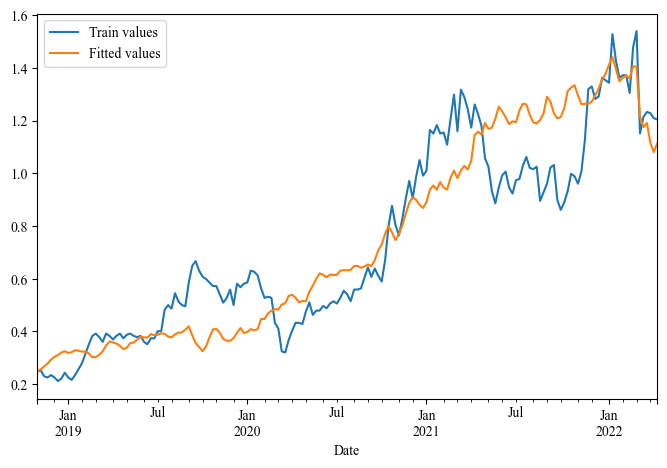

In [124]:
fig, ax = plt.subplots(figsize=(8, 5))
    
train_data[endog].cumsum().plot(ax=ax)
    
res.fittedvalues.cumsum().plot(ax=ax)

ax.legend(['Train values', 'Fitted values'])

# plt.savefig('images/FittedValue.png', dpi=300)

In [116]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(train_data[endog], res.fittedvalues)

1442866722999.193

In [117]:
from sklearn.metrics import mean_squared_error

mean_squared_error(train_data[endog], res.fittedvalues)

0.0029384924015728848

In [118]:
test_data.append(train_data.cumsum().iloc[-1]).sort_index()

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_88643/2818503879.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data.append(train_data.cumsum().iloc[-1]).sort_index()


,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
Date,,,,,,,
2022-04-15 00:00:00+10:00,1.204023,2958320.75,97.85,1.849994e+06,3.883586e+06,2.139688e+07,163025.30
2022-04-22 00:00:00+10:00,-0.067157,33836.50,0.10,1.059266e+04,3.803533e+04,1.998633e+05,1471.16
2022-04-29 00:00:00+10:00,0.124720,32424.00,0.10,1.033434e+04,3.803533e+04,1.998633e+05,1471.16
2022-05-06 00:00:00+10:00,-0.057563,29927.50,0.35,1.031661e+04,3.803533e+04,1.998633e+05,1471.16
2022-05-13 00:00:00+10:00,-0.100735,27399.00,0.35,1.006944e+04,3.803533e+04,1.998633e+05,1471.16
2022-05-20 00:00:00+10:00,0.134313,27925.00,0.35,1.030599e+04,3.803533e+04,1.998633e+05,1471.16
2022-05-27 00:00:00+10:00,-0.057563,27826.00,0.35,1.035954e+04,3.803533e+04,1.998633e+05,1471.16
2022-06-03 00:00:00+10:00,0.062360,27706.00,0.35,1.048043e+04,3.803533e+04,1.998633e+05,1400.81
2022-06-10 00:00:00+10:00,-0.124720,27567.50,0.85,1.038661e+04,3.803533e+04,1.998633e+05,1400.81


In [119]:
first_value = pd.DataFrame(data=[{
    'mean': train_data.cumsum().iloc[-1]['NIC'], 
    'mean_se': train_data.cumsum().iloc[-1]['NIC'], 
    'mean_ci_lower': train_data.cumsum().iloc[-1]['NIC'], 
    'mean_ci_upper': train_data.cumsum().iloc[-1]['NIC'],}], index=[train_data.index[-1]])

In [120]:
train_data.cumsum().iloc[-1]

NIC                            1.204023e+00
Nickle price                   2.958321e+06
Rate                           9.785000e+01
AUD/IDR                        1.849994e+06
NPI production                 3.883586e+06
Mining                         2.139688e+07
Metal products in indonesia    1.630253e+05
Name: 2022-04-15 00:00:00+10:00, dtype: float64

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_88643/26399235.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predicted_value_for_figure = predicted_value.append(first_value).sort_index()


meanabs 0.07227284435457791
mse 0.007452854238500915
rmse 0.08632991508452278


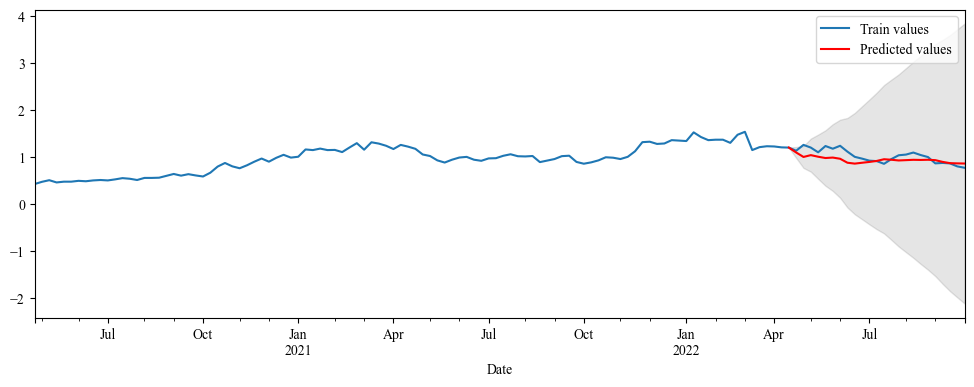

In [129]:
predicted_value = res.get_prediction(test_data.index[0], test_data.index[-1], exog=test_data[exog]).summary_frame()

predicted_value_for_figure = predicted_value.append(first_value).sort_index()

fig, ax = plt.subplots(figsize=(8, 4))
# test_data.append(train_data.cumsum().iloc[-1]).cumsum().sort_index()[endog].plot(ax=ax)
data[endog]["2021-04-20":].plot(ax=ax)

predicted_value_for_figure['mean'].cumsum().plot(ax=ax, color='red')
ax.fill_between(
        predicted_value_for_figure.index, 
        predicted_value_for_figure['mean_ci_lower'].cumsum(), 
        predicted_value_for_figure['mean_ci_upper'].cumsum(), 
        color='k',
        alpha=0.1);

ax.legend(['Train values', 'Predicted values'])

# plt.savefig('images/PredictedValue.png', dpi=300)

from statsmodels.tools.eval_measures import meanabs, mse, rmse

    
print('meanabs', meanabs(test_data[endog], predicted_value['mean']))
print('mse', mse(test_data[endog], predicted_value['mean']))
print('rmse', rmse(test_data[endog], predicted_value['mean']))

In [70]:
import time
from datetime import datetime
import numpy as np

def ARIMAGridSearch(y_train, x_train, p_params, q_params, d_params):
    # Create dictionary to store MAPEs
    mape_grid = dict()
    rmse_grid = dict()
    grid = dict()
    # Outer loop: Iterate through possible values for `p`
    for p in p_params:
        # Create key-value pair in dict. Key is `p`, value is empty list.
        mape_grid[p] = list()
        rmse_grid[p] = list()
        # Inner loop: Iterate through possible values for `q`
        for q in q_params:
            # Combination of hyperparameters for model
            order = (p, d_params, q)
            # Note start time
            start_time = time.time()
            # Train model
            model = sm.tsa.arima.ARIMA(y_train, exog=x_train, order=order).fit()
            # Generate in-sample (training) predictions
            y_pred = model.predict()
            # Calculate training MAE
            mape = mean_absolute_percentage_error(y_train, y_pred)
            mse = mean_squared_error(y_train, y_pred, squared=False)
            # Calculate model training time
            elapsed_time = round(time.time() - start_time, 2)
            print(f"Trained ARIMA {order} in {elapsed_time} seconds. MAPE is {mape.round(6)}. RMSE is {mse.round(6)}")
            grid[order] = [order, mape.round(6), mse.round(6)]
            # Append MAE to list in dictionary
            mape_grid[p].append(mape)
            rmse_grid[p].append(mse)
            
    
    cols = ['AR' + str(x) for x in p_params]
    index = ['MA' + str(x) for x in q_params]
    grid_arima_mape = pd.DataFrame.from_dict(mape_grid)
    grid_arima_mape.columns = cols
    grid_arima_mape.index = index
    grid_arima_rmse = pd.DataFrame.from_dict(rmse_grid)
    grid_arima_rmse.columns = cols
    grid_arima_rmse.index = index
    
    return grid_arima_mape, grid_arima_rmse, grid

In [71]:
p_params = range(0, 10, 1)
q_params = range(0, 10, 1)
d_params = 0

ARIMAGridSearch(train_data[endog], train_data[exog], p_params = p_params, q_params = q_params, d_params = 0)


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (0, 0, 0) in 0.18 seconds. MAPE is 1126075432984.5852. RMSE is 0.061988
Trained ARIMA (0, 0, 1) in 0.16 seconds. MAPE is 1022963084868.7551. RMSE is 0.061908


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (0, 0, 2) in 0.22 seconds. MAPE is 1247756170070.4707. RMSE is 0.060844


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (0, 0, 3) in 0.26 seconds. MAPE is 1109044868126.741. RMSE is 0.060801


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (0, 0, 4) in 0.26 seconds. MAPE is 1503077440967.723. RMSE is 0.060512


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (0, 0, 5) in 0.32 seconds. MAPE is 1580919275882.6165. RMSE is 0.060387


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (0, 0, 6) in 0.72 seconds. MAPE is 1501027978908.9294. RMSE is 0.059612


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (0, 0, 7) in 0.79 seconds. MAPE is 2274427628529.4604. RMSE is 0.059393


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (0, 0, 8) in 0.83 seconds. MAPE is 1928773770038.8726. RMSE is 0.058547


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (0, 0, 9) in 0.96 seconds. MAPE is 2006135855248.411. RMSE is 0.05853
Trained ARIMA (1, 0, 0) in 0.15 seconds. MAPE is 1024537491306.8595. RMSE is 0.061932


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (1, 0, 1) in 0.2 seconds. MAPE is 1022957159278.0695. RMSE is 0.06191
Trained ARIMA (1, 0, 2) in 0.21 seconds. MAPE is 1287567001348.6077. RMSE is 0.060811


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (1, 0, 3) in 0.24 seconds. MAPE is 1350756539439.1482. RMSE is 0.060661


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (1, 0, 4) in 0.31 seconds. MAPE is 1475347218737.742. RMSE is 0.060486


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (1, 0, 5) in 0.31 seconds. MAPE is 1569201765992.8293. RMSE is 0.060294


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (1, 0, 6) in 0.8 seconds. MAPE is 1599207466084.6091. RMSE is 0.059558


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (1, 0, 7) in 0.84 seconds. MAPE is 2262454580294.5327. RMSE is 0.05937


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (1, 0, 8) in 1.0 seconds. MAPE is 2012142622034.5684. RMSE is 0.058432


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (1, 0, 9) in 1.06 seconds. MAPE is 2025670379960.3833. RMSE is 0.058526
Trained ARIMA (2, 0, 0) in 0.17 seconds. MAPE is 1372090750438.8452. RMSE is 0.060676


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (2, 0, 1) in 0.21 seconds. MAPE is 1307146451349.8655. RMSE is 0.060655


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (2, 0, 2) in 0.23 seconds. MAPE is 1388850855472.242. RMSE is 0.060637


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (2, 0, 3) in 0.3 seconds. MAPE is 1673301023670.696. RMSE is 0.060689


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (2, 0, 4) in 0.32 seconds. MAPE is 1633748638775.4775. RMSE is 0.060974


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (2, 0, 5) in 0.32 seconds. MAPE is 1635332119917.935. RMSE is 0.060638


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (2, 0, 6) in 0.88 seconds. MAPE is 1543955774539.5894. RMSE is 0.059019


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (2, 0, 7) in 1.12 seconds. MAPE is 2321995505468.83. RMSE is 0.058895


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (2, 0, 8) in 1.66 seconds. MAPE is 2341785776370.2964. RMSE is 0.058545


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (2, 0, 9) in 1.32 seconds. MAPE is 2135920002297.1892. RMSE is 0.058659


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (3, 0, 0) in 0.24 seconds. MAPE is 1326060772203.9937. RMSE is 0.060651


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (3, 0, 1) in 0.27 seconds. MAPE is 1329030723655.8542. RMSE is 0.060651


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (3, 0, 2) in 0.23 seconds. MAPE is 1126075432984.5852. RMSE is 0.061988


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (3, 0, 3) in 0.29 seconds. MAPE is 1556627163252.66. RMSE is 0.060805


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (3, 0, 4) in 0.47 seconds. MAPE is 1636077004202.6743. RMSE is 0.060792


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (3, 0, 5) in 0.62 seconds. MAPE is 1624762579858.6565. RMSE is 0.060436


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (3, 0, 6) in 1.09 seconds. MAPE is 1548867413068.0552. RMSE is 0.059008


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (3, 0, 7) in 0.98 seconds. MAPE is 2428281028381.542. RMSE is 0.059061


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (3, 0, 8) in 1.1 seconds. MAPE is 2374153289737.363. RMSE is 0.058596


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (3, 0, 9) in 1.19 seconds. MAPE is 2185828875727.106. RMSE is 0.058715


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 0) in 0.26 seconds. MAPE is 1327501032854.2917. RMSE is 0.060655


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (4, 0, 1) in 0.27 seconds. MAPE is 1331891540801.6448. RMSE is 0.060655


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 2) in 0.28 seconds. MAPE is 1126075432984.5852. RMSE is 0.061988


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 3) in 0.29 seconds. MAPE is 1461460675081.305. RMSE is 0.061089


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 4) in 0.76 seconds. MAPE is 1901518318770.046. RMSE is 0.058616


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 5) in 0.35 seconds. MAPE is 1500797109770.1833. RMSE is 0.059037


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 6) in 0.95 seconds. MAPE is 1400322280773.086. RMSE is 0.058348


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 7) in 0.99 seconds. MAPE is 2465518531344.516. RMSE is 0.058585


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 8) in 1.28 seconds. MAPE is 2362281370178.716. RMSE is 0.058134


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (4, 0, 9) in 1.3 seconds. MAPE is 2090590076145.8142. RMSE is 0.058001


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (5, 0, 0) in 0.28 seconds. MAPE is 1541006983793.9385. RMSE is 0.060601


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (5, 0, 1) in 0.38 seconds. MAPE is 1544638155442.5396. RMSE is 0.060612


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (5, 0, 2) in 0.32 seconds. MAPE is 1126075432984.5852. RMSE is 0.061988


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (5, 0, 3) in 0.33 seconds. MAPE is 1510759806259.8428. RMSE is 0.06146


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (5, 0, 4) in 0.34 seconds. MAPE is 1937949047241.04. RMSE is 0.058638


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (5, 0, 5) in 0.38 seconds. MAPE is 5458103037529.266. RMSE is 0.079997


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (5, 0, 6) in 1.01 seconds. MAPE is 1091266202060.967. RMSE is 0.058372


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (5, 0, 7) in 1.05 seconds. MAPE is 2149129668278.011. RMSE is 0.057829


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (5, 0, 8) in 1.31 seconds. MAPE is 2144219599021.7825. RMSE is 0.057791


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (5, 0, 9) in 1.69 seconds. MAPE is 1329511298889.3923. RMSE is 0.057349


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (6, 0, 0) in 0.3 seconds. MAPE is 1416778834748.8787. RMSE is 0.059561


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (6, 0, 1) in 0.39 seconds. MAPE is 1418450111129.0977. RMSE is 0.059517


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Trained ARIMA (6, 0, 2) in 0.78 seconds. MAPE is 1454291287950.9727. RMSE is 0.059674


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (6, 0, 3) in 0.36 seconds. MAPE is 11605470991361.453. RMSE is 0.191417


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (6, 0, 4) in 0.97 seconds. MAPE is 1509370730934.208. RMSE is 0.057846


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (6, 0, 5) in 0.39 seconds. MAPE is 4501800106905.393. RMSE is 0.07521


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (6, 0, 6) in 1.23 seconds. MAPE is 2802190528513.5586. RMSE is 0.060801


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (6, 0, 7) in 1.04 seconds. MAPE is 2001665974546.894. RMSE is 0.057493


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (6, 0, 8) in 1.29 seconds. MAPE is 2069896996013.855. RMSE is 0.057493


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (6, 0, 9) in 1.45 seconds. MAPE is 1297959114314.122. RMSE is 0.057367


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 0) in 0.82 seconds. MAPE is 2257022692697.3906. RMSE is 0.058537


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 1) in 0.94 seconds. MAPE is 2349440894553.83. RMSE is 0.058588


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 2) in 0.99 seconds. MAPE is 2370572574209.5146. RMSE is 0.058792


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 3) in 1.03 seconds. MAPE is 3046137775786.6455. RMSE is 0.062763


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 4) in 1.07 seconds. MAPE is 2259802624462.017. RMSE is 0.05845


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 5) in 1.09 seconds. MAPE is 2310995920077.759. RMSE is 0.058344


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 6) in 1.13 seconds. MAPE is 2095206312934.189. RMSE is 0.0576


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 7) in 1.09 seconds. MAPE is 1930560551858.479. RMSE is 0.0574


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 8) in 1.42 seconds. MAPE is 2075880149328.054. RMSE is 0.057473


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (7, 0, 9) in 1.31 seconds. MAPE is 1284345898907.6978. RMSE is 0.057384


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 0) in 0.78 seconds. MAPE is 2036209385221.064. RMSE is 0.058251


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 1) in 0.85 seconds. MAPE is 2106881474022.4053. RMSE is 0.058252


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 2) in 0.85 seconds. MAPE is 2107546648957.7686. RMSE is 0.058256


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (8, 0, 3) in 0.8 seconds. MAPE is 2039484347736.54. RMSE is 0.05803


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 4) in 0.38 seconds. MAPE is 1126075432984.5852. RMSE is 0.061988


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 5) in 1.0 seconds. MAPE is 1120978477024.9949. RMSE is 0.058579


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 6) in 1.12 seconds. MAPE is 1927197759734.4534. RMSE is 0.05802


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 7) in 1.19 seconds. MAPE is 2002838789127.8442. RMSE is 0.057416


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 8) in 1.39 seconds. MAPE is 1613094296820.9583. RMSE is 0.057343


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (8, 0, 9) in 1.87 seconds. MAPE is 1318471240636.3193. RMSE is 0.057627


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (9, 0, 0) in 0.97 seconds. MAPE is 1972153972023.8105. RMSE is 0.058242


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (9, 0, 1) in 1.33 seconds. MAPE is 2039537022138.4675. RMSE is 0.058235


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (9, 0, 2) in 1.11 seconds. MAPE is 2046409391657.0667. RMSE is 0.058167


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (9, 0, 3) in 1.21 seconds. MAPE is 2005092243763.7334. RMSE is 0.058156


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (9, 0, 4) in 0.5 seconds. MAPE is 1126075432984.5852. RMSE is 0.061988


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (9, 0, 5) in 1.41 seconds. MAPE is 1074542037409.8. RMSE is 0.058599


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (9, 0, 6) in 0.64 seconds. MAPE is 1126075432984.5852. RMSE is 0.061988


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Trained ARIMA (9, 0, 7) in 1.4 seconds. MAPE is 2856928666120.393. RMSE is 0.058261


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMA (9, 0, 8) in 0.61 seconds. MAPE is 1126075432984.5852. RMSE is 0.061988
Trained ARIMA (9, 0, 9) in 1.88 seconds. MAPE is 1436509169401.29. RMSE is 0.058688


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(              AR0           AR1           AR2           AR3           AR4  \
 MA0  1.126075e+12  1.024537e+12  1.372091e+12  1.326061e+12  1.327501e+12   
 MA1  1.022963e+12  1.022957e+12  1.307146e+12  1.329031e+12  1.331892e+12   
 MA2  1.247756e+12  1.287567e+12  1.388851e+12  1.126075e+12  1.126075e+12   
 MA3  1.109045e+12  1.350757e+12  1.673301e+12  1.556627e+12  1.461461e+12   
 MA4  1.503077e+12  1.475347e+12  1.633749e+12  1.636077e+12  1.901518e+12   
 MA5  1.580919e+12  1.569202e+12  1.635332e+12  1.624763e+12  1.500797e+12   
 MA6  1.501028e+12  1.599207e+12  1.543956e+12  1.548867e+12  1.400322e+12   
 MA7  2.274428e+12  2.262455e+12  2.321996e+12  2.428281e+12  2.465519e+12   
 MA8  1.928774e+12  2.012143e+12  2.341786e+12  2.374153e+12  2.362281e+12   
 MA9  2.006136e+12  2.025670e+12  2.135920e+12  2.185829e+12  2.090590e+12   
 
               AR5           AR6           AR7           AR8           AR9  
 MA0  1.541007e+12  1.416779e+12  2.257023e+12  2.036209e+12  1